In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import math
%pylab inline
%reload_ext autoreload
%autoreload 2


Populating the interactive namespace from numpy and matplotlib


/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("smartmeters.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet

In [5]:
# Params
device='cuda'
batch_size=32
num_workers=5
use_logy=False
num_context, num_extra_target = 24*2*3, 24*2
esp=1e-4

# Load kaggle smart meter data

In [6]:
csv_files = sorted(Path('data/smart-meters-in-london/halfhourly_dataset').glob('*.csv'))[:1]
df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in tqdm(csv_files)])
print(df.info())

df = df.groupby('tstp').mean()
df['tstp'] = df.index
df.index.name = ''
df.head(3)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222670 entries, 0 to 1222669
Data columns (total 3 columns):
LCLid             1222670 non-null object
tstp              1222670 non-null datetime64[ns]
energy(kWh/hh)    1222620 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 28.0+ MB
None


,energy(kWh/hh),tstp
,,
2011-12-03 09:00:00,0.149,2011-12-03 09:00:00
2011-12-03 09:30:00,0.154,2011-12-03 09:30:00
2011-12-03 10:00:00,0.768,2011-12-03 10:00:00


In [7]:
# Load weather data
df_weather = pd.read_csv('data/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=[3])

use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 
       'humidity']
df_weather = df_weather[use_cols].set_index('time')

# Resample to match energy data    
df_weather = df_weather.resample('30T').ffill()

# Normalise
weather_norms=dict(mean={'visibility': 11.2,
 'windBearing': 195.7,
 'temperature': 10.5,
 'dewPoint': 6.5,
 'pressure': 1014.1,
 'apparentTemperature': 9.2,
 'windSpeed': 3.9,
 'humidity': 0.8},
std={'visibility': 3.1,
 'windBearing': 90.6,
 'temperature': 5.8,
 'dewPoint': 5.0,
 'pressure': 11.4,
 'apparentTemperature': 6.9,
 'windSpeed': 2.0,
 'humidity': 0.1})

for col in df_weather.columns:
    df_weather[col] -= weather_norms['mean'][col]
    df_weather[col] /= weather_norms['std'][col]

    
print(len(df))
df = pd.concat([df, df_weather], 1).dropna()
len(df)

39292


39225

In [8]:
# Also find bank holidays
df_hols = pd.read_csv('./data/smart-meters-in-london/uk_bank_holidays.csv', parse_dates=[0])
holidays = set(df_hols['Bank holidays'].dt.round('D'))

df['holiday'] = df.tstp.apply(lambda dt:dt.floor('D') in holidays).astype(int)

In [9]:
# Add time features
time = df.tstp
df["month"] = time.dt.month / 12.0
df['day'] = time.dt.day / 310.0
df['week'] = time.dt.week / 52.0
df['hour'] = time.dt.hour / 24.0
df['minute'] = time.dt.minute / 24.0
df['dayofweek'] = time.dt.dayofweek / 7.0

In [10]:
# Drop nan and 0's
df = df[df['energy(kWh/hh)']!=0]
df = df.dropna()

if use_logy:
    df['energy(kWh/hh)'] = np.log(df['energy(kWh/hh)']+eps)
df = df.sort_values('tstp')
df.describe()

,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,month,day,week,hour,minute,dayofweek
count,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000,39225.000000
mean,0.449333,0.029285,0.018890,0.005533,0.009592,-0.010061,0.010214,0.013695,-0.202741,0.021976,0.529373,0.050786,0.495566,0.479369,0.624984,0.428291
std,0.218992,0.959951,1.002480,1.021497,1.030993,1.005238,1.030426,1.020799,1.401747,0.146606,0.306145,0.028288,0.307568,0.288379,0.625008,0.285822
min,0.023000,-3.525806,-2.160044,-2.782759,-3.296000,-3.364912,-2.620290,-1.930000,-5.700000,0.000000,0.083333,0.003226,0.019231,0.000000,0.000000,0.000000
25%,0.293000,-0.270968,-0.758278,-0.706897,-0.756000,-0.594737,-0.791304,-0.740000,-1.000000,0.000000,0.250000,0.025806,0.211538,0.250000,0.000000,0.142857
50%,0.436444,0.358065,0.257174,-0.089655,0.022000,0.034211,0.078261,-0.095000,0.100000,0.000000,0.500000,0.051613,0.480769,0.500000,0.000000,0.428571
75%,0.583932,0.606452,0.676600,0.712069,0.794000,0.680702,0.786957,0.605000,0.900000,0.000000,0.833333,0.074194,0.769231,0.750000,1.250000,0.714286
max,1.981000,1.577419,1.802428,3.775862,2.676000,2.563158,3.365217,5.450000,2.000000,1.000000,1.000000,0.100000,1.000000,0.958333,1.250000,0.857143


In [11]:
# split data
n_split = -int(len(df)*0.1)
df_train = df[:n_split]
df_test = df[n_split:]
len(df_train), len(df_test)

(35303, 3922)

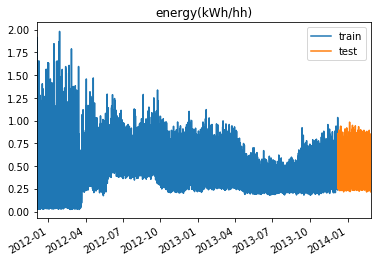

In [12]:
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Plot helpers

In [13]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std, undo_log=use_logy, legend=False):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    if undo_log:
        target_y=np.exp(target_y)-eps
        context_y=np.exp(context_y)-eps
    # Plot everything 
    # Note: days is first feature in x, since we made sure of that in the dataloader)
    j=0
    
    plt.plot(target_x[0,:,j], target_y[0], 'k:', linewidth=2, label='true')
    plt.plot(context_x[0,:,j], context_y[0], 'ko', markersize=6, label='input data')
    ylims=plt.ylim()
    plt.plot(target_x[0,:,j], pred_y[0], 'b', linewidth=2, label='predicted')
    plt.fill_between(
          target_x[0, :, j],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.25,
          facecolor='blue',
          interpolate=True,
    label='uncertainty')

    # Make the plot pretty
    plt.grid('off')
    plt.ylim(*ylims)
    plt.xlabel('Days')
    plt.ylabel('Energy (kWh/hh)')
    plt.grid(b=None)
    if legend:
        plt.legend()
    ax = plt.gca()
    plt.show()

In [14]:
def plot_from_loader(loader, i=0, undo_log=use_logy, title='', plot=True, legend=False):
    data = loader.collate_fn([loader.dataset[i]])
    data = [d.to(device) for d in data]
    context_x, context_y, target_x, target_y = data

    model.eval()
    with torch.no_grad():
        y_pred, kl, loss_test, y_std = model(context_x, context_y, target_x, target_y)

        if plot:
            plt.title(title+f" loss={loss_test: 2.2g}")
            plot_functions(target_x.detach().cpu().numpy(),
                            target_y.detach().cpu().numpy(),
                            context_x.detach().cpu().numpy(),
                            context_y.detach().cpu().numpy(),
                            y_pred.detach().cpu().numpy(),
                            y_std.detach().cpu().numpy(), undo_log=undo_log, legend=legend)
    return loss_test

# Dataloaders

In [15]:
data_train = SmartMeterDataSet(df_train, num_context, num_extra_target)
data_test = SmartMeterDataSet(df_test, num_context, num_extra_target)

In [16]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=True),
    num_workers=num_workers,
)

loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False, 
    collate_fn=collate_fns(num_context, num_extra_target, sample=False)
)

# Run

In [17]:
x, y, _, _ = next(iter(loader_train))
x.shape, y.shape

(torch.Size([32, 24, 16]), torch.Size([32, 24, 1]))

In [18]:
from torch import nn
import torch.nn.functional as F

class CausalConv1d(nn.Conv1d):
    """
    CausalConv1d which only pads on the left.

    See: https://github.com/iwasaki-kenta/keita/blob/master/layers/convolution.py#L40
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):
        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)

        self.left_padding = dilation * (kernel_size - 1)

    def forward(self, input):
        x = F.pad(input.unsqueeze(2), (self.left_padding, 0, 0, 0)).squeeze(2)

        return super(CausalConv1d, self).forward(x)


In [30]:


class NPBlockRelu2d(nn.Module):
    """Block for Neural Processes."""

    def __init__(self, in_channels, out_channels, dropout=0, norm=True):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout2d(dropout)
        self.norm = nn.BatchNorm2d(out_channels) if norm else False

    def forward(self, x):
        # x.shape is (Batch, Sequence, Channels)
        # We pass a linear over it which operates on the Channels
        x = self.act(self.linear(x))

        # Now we want to apply batchnorm and dropout to the channels. So we put it in shape
        # (Batch, Channels, Sequence, None) so we can use Dropout2d
        x = x.permute(0, 2, 1)[:, :, :, None]

        if self.norm:
            x = self.norm(x)

        x = self.dropout(x)
        return x[:, :, :, 0].permute(0, 2, 1)


def block_relu(in_dim, out_dim, dropout=0, inplace=False):
    return nn.Sequential(
        nn.Linear(in_dim, out_dim),
        nn.ReLU(inplace=inplace),
        nn.BatchNorm1d(out_dim),
        nn.Dropout(dropout, inplace=inplace),
    )


class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type, n_heads=8, dropout=0):
        super().__init__()
        if attention_type == "uniform":
            self._attention_func = self._uniform_attention
        elif attention_type == "laplace":
            self._attention_func = self._laplace_attention
        elif attention_type == "dot":
            self._attention_func = self._dot_attention
        elif attention_type == "multihead":
            self._mattn = torch.nn.MultiheadAttention(
                hidden_dim, n_heads, bias=False, dropout=dropout
            )
            self._attention_func = self._pytorch_multihead_attention
            self.n_heads = n_heads
        else:
            raise NotImplementedError

    def forward(self, k, v, q):
        rep = self._attention_func(k, v, q)
        return rep

    def _uniform_attention(self, k, v, q):
        total_points = q.shape[1]
        rep = torch.mean(v, dim=1, keepdim=True)
        rep = rep.repeat(1, total_points, 1)
        return rep

    def _laplace_attention(self, k, v, q, scale=0.5):
        k_ = k.unsqueeze(1)
        v_ = v.unsqueeze(2)
        unnorm_weights = torch.abs((k_ - v_) * scale)
        unnorm_weights = unnorm_weights.sum(dim=-1)
        weights = torch.softmax(unnorm_weights, dim=-1)
        rep = torch.einsum("bik,bkj->bij", weights, v)
        return rep

    def _dot_attention(self, k, v, q):
        scale = q.shape[-1] ** 0.5
        unnorm_weights = torch.einsum("bjk,bik->bij", k, q) / scale
        weights = torch.softmax(unnorm_weights, dim=-1)

        rep = torch.einsum("bik,bkj->bij", weights, v)
        return rep

    def _pytorch_multihead_attention(self, k, v, q):
        # Pytorch multiheaded attention takes inputs if diff order and permutation
        o = self._mattn(q.permute(1, 0, 2), k.permute(1, 0, 2), v.permute(1, 0, 2))[0]
        return o.permute(1, 0, 2)


    
class LatentEncoder(nn.Module):
    """
    Latent Encoder [For prior, posterior]
    """
    def __init__(
        self,
        input_dim,
        hidden_dim=32,
        latent_dim=32,
        n_heads=4,
        self_attention_type="multihead",
        n_encoder_layers=3,
        dropout=0,
        attention_dropout=0,
    ):
        super().__init__()
        self._input_layer = NPBlockRelu2d(input_dim, hidden_dim, dropout)
        self._encoder = nn.Sequential(
            *[
                NPBlockRelu2d(hidden_dim, hidden_dim, dropout)
                for _ in range(n_encoder_layers)
            ]
        )
        self._self_attention = Attention(
            hidden_dim, self_attention_type, n_heads=n_heads, dropout=attention_dropout
        )
        self._penultimate_layer = block_relu(hidden_dim, hidden_dim, dropout)
        self._mean = nn.Linear(hidden_dim, latent_dim)
        self._log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, y):
        """Encodes the inputs into one representation.

        Args:
        x: Tensor of shape [B,observations,d_x]. For this 1D regression
            task this corresponds to the x-values.
        y: Tensor of shape [B,observations,d_y]. For this 1D regression
            task this corresponds to the y-values.

        Returns:
        - A normal distribution over tensors of shape [B, num_latents]
        - log_var
        """
        # Concat location (x) and value (y) along the filter axes
        encoder_input = torch.cat([x, y], dim=-1)

        # Pass final axis through MLP
        encoded = self._input_layer(encoder_input)
        encoded = self._encoder(encoded)

        # Self-attention aggregator
        attention_output = self._self_attention(encoded, encoded, encoded)
        mean_repr = attention_output.mean(dim=1)

        # Have further MLP layers
        mean_repr = self._penultimate_layer(mean_repr)

        return mean_repr

In [78]:
def causalconv1d_relu_block(in_channels, out_channels, dropout=0, **kwargs):
    return nn.Sequential(
        CausalConv1d(in_channels, out_channels, **kwargs),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(out_channels),
        nn.Dropout(dropout), )


def relu_block(in_channels, out_channels, dropout=0, **kwargs):
    return nn.Sequential(
        nn.Linear(in_channels, out_channels, **kwargs),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(out_channels),
        nn.Dropout(dropout), )


class LSTM1d(nn.Module):
    """Simple LSTM model to predict seq of y given seq of x."""

    def __init__(self,
                 channels,
                 num_outputs,
                 lstm_channels=32,
                 head_features=32,
                 attention_dropout=0,
                 dropout=0,
                 lstm_dropout=0,
                 lstm_layers=2,
                 bidirectional=False):
        super().__init__()
        self.num_outputs = num_outputs
        encoder_channels = lstm_channels

        self.encoder = LatentEncoder(
            channels + num_outputs,
            hidden_dim=encoder_channels,
            latent_dim=encoder_channels,
            dropout=dropout,
            attention_dropout=attention_dropout,
            #             n_heads=num_heads,
        )
        self.pre_lstm = nn.Sequential(
            # 1x1 to reduce channels
            causalconv1d_relu_block(
                channels + encoder_channels,
                lstm_channels,
                kernel_size=1,
                dropout=dropout, ))
        self.lstm = nn.Sequential(
            nn.LSTM(
                lstm_channels,
                lstm_channels,
                num_layers=lstm_layers,
                bidirectional=bidirectional,
                batch_first=True,
                dropout=lstm_dropout, ), )

        # head to reduce features
        self.output = nn.Sequential(
            nn.LSTM(
                lstm_channels,
                num_outputs * 2,
                num_layers=1,
                bidirectional=False,
                batch_first=True,
                dropout=lstm_dropout, ))

    def forward(self, context_x, context_y, target_x, target_y=None):
        # First encode context like in Neural processes
        z = self.encoder(context_x, context_y)
        z = z.unsqueeze(1).repeat(1, target_x.shape[1],
                                  1)  # [B, T_target, H]  
        x = torch.cat([target_x, z], -1).permute([0, 2, 1])
        data = self.pre_lstm(x).permute([0, 2, 1])
        data = self.lstm(data)[0]  #[:, -1]
        target_y_pred = self.output(data)[0]

        loc = target_y_pred[:, :, :self.num_outputs]
        log_scale = target_y_pred[:, :, self.num_outputs:] + math.log(0.1)
        scale = log_scale.exp()

        dist = torch.distributions.Normal(loc=loc, scale=scale)

        if target_y is not None:
            loss = -dist.log_prob(target_y).mean()
        else:
            loss = None

        y_pred = dist.rsample() if self.training else dist.loc

        return y_pred, torch.Tensor([0]), loss, dist.scale

In [79]:
from src.models.model import LatentModel
model = LSTM1d(
    x.shape[-1],
    y.shape[-1],
    lstm_channels=64,
    head_features=64,
    attention_dropout=0.5,
    dropout=0.5,
    lstm_layers=3, ).cuda()

optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [80]:
from torchsummaryX import summary
data = next(iter(loader_train))
data = [d.to(device) for d in data]
context_x, context_y, target_x, target_y = data
with torch.no_grad():
    model.eval()
    summary(model, context_x, context_y, target_x, target_y)
    dist, log_p, kl, loss = model(context_x, context_y, target_x, target_y)

                                            Kernel Shape     Output Shape  Params Mult-Adds
Layer                                                                                      
0_encoder._input_layer.Linear_linear            [17, 64]     [32, 85, 64]  1.152k    1.088k
1_encoder._input_layer.ReLU_act                        -     [32, 85, 64]       -         -
2_encoder._input_layer.BatchNorm2d_norm             [64]  [32, 64, 85, 1]   128.0      64.0
3_encoder._input_layer.Dropout2d_dropout               -  [32, 64, 85, 1]       -         -
4_encoder._encoder.0.Linear_linear              [64, 64]     [32, 85, 64]   4.16k    4.096k
5_encoder._encoder.0.ReLU_act                          -     [32, 85, 64]       -         -
6_encoder._encoder.0.BatchNorm2d_norm               [64]  [32, 64, 85, 1]   128.0      64.0
7_encoder._encoder.0.Dropout2d_dropout                 -  [32, 64, 85, 1]       -         -
8_encoder._encoder.1.Linear_linear              [64, 64]     [32, 85, 64]   4.16

In [81]:

import gc
gc.collect()
torch.cuda.empty_cache()

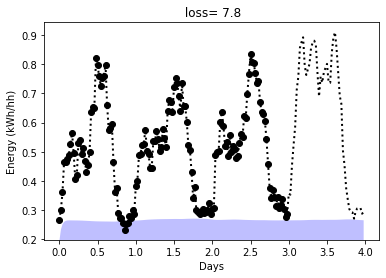

tensor(7.8092, device='cuda:0')

In [82]:
# Lets choose a challenging time to forecast
vis_i = 670 # 290 # 1600
plot_from_loader(loader_test, i=vis_i)

0, i=0, loss: 5.768, test: 7.515, grad_norm:  41, std:  0.093
0, i=100, loss: 0.2087, test: -0.2747, grad_norm:  2.5, std:  0.17
0, i=200, loss: -0.002053, test: -0.2114, grad_norm:  0.9, std:  0.21
0, i=300, loss: -0.09488, test: -0.1667, grad_norm:  0.86, std:  0.22
0, i=400, loss: -0.03811, test: -0.1727, grad_norm:  0.76, std:  0.22
0, i=500, loss: -0.1242, test: -0.1593, grad_norm:  1.1, std:  0.22
0, i=600, loss: -0.03449, test: -0.1488, grad_norm:  1.1, std:  0.22
0, i=700, loss: -0.1181, test: -0.1834, grad_norm:  0.98, std:  0.21
0, i=800, loss: 0.1278, test: -0.1871, grad_norm:  1.3, std:  0.2
0, i=900, loss: 0.01511, test: -0.2201, grad_norm:  1.2, std:  0.21
0, i=1000, loss: -0.1683, test: -0.2668, grad_norm:  1.4, std:  0.21


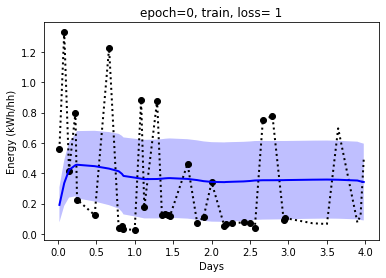

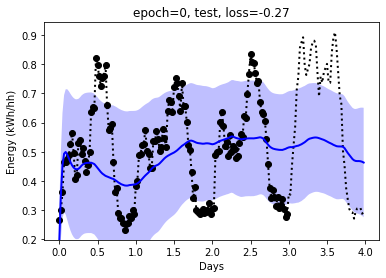

epoch: 0, loss: -0.2202, loss_test:-0.2662, kl= 0, grad_norm:  2.7


1, i=0, loss: -0.09894, test: -0.2629, grad_norm:  0.97, std:  0.21
1, i=100, loss: -0.08838, test: -0.2748, grad_norm:  1.1, std:  0.21
1, i=200, loss: -0.1157, test: -0.2801, grad_norm:  1.1, std:  0.21
1, i=300, loss: -0.205, test: -0.2776, grad_norm:  1, std:  0.2
1, i=400, loss: -0.2835, test: -0.2848, grad_norm:  1.2, std:  0.21
1, i=500, loss: -0.151, test: -0.3071, grad_norm:  1.3, std:  0.21
1, i=600, loss: -0.08729, test: -0.3039, grad_norm:  1.6, std:  0.2
1, i=700, loss: 0.1926, test: -0.3186, grad_norm:  1.4, std:  0.21
1, i=800, loss: -0.09812, test: -0.3542, grad_norm:  1.9, std:  0.21
1, i=900, loss: -0.2128, test: -0.3156, grad_norm:  1.1, std:  0.21
1, i=1000, loss: -0.1353, test: -0.3432, grad_norm:  1.2, std:  0.21


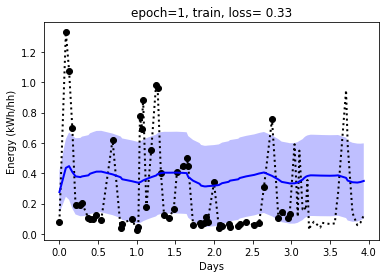

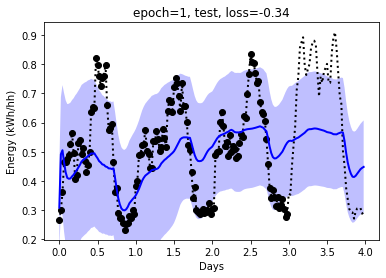

epoch: 1, loss: -0.2531, loss_test:-0.344, kl= 0, grad_norm:  3.6


2, i=0, loss: -0.0647, test: -0.3465, grad_norm:  1.7, std:  0.21
2, i=100, loss: -0.2388, test: -0.3861, grad_norm:  1.2, std:  0.2
2, i=200, loss: -0.1121, test: -0.4183, grad_norm:  1.2, std:  0.2
2, i=300, loss: -0.1985, test: -0.4, grad_norm:  1.6, std:  0.2
2, i=400, loss: -0.3176, test: -0.4323, grad_norm:  1.1, std:  0.2
2, i=500, loss: -0.2189, test: -0.4728, grad_norm:  1.2, std:  0.2
2, i=600, loss: -0.2511, test: -0.3857, grad_norm:  6.8, std:  0.19
2, i=700, loss: -0.2518, test: -0.5336, grad_norm:  2.6, std:  0.19
2, i=800, loss: -0.2083, test: -0.5233, grad_norm:  1.9, std:  0.19
2, i=900, loss: -0.356, test: -0.5467, grad_norm:  1.5, std:  0.19
2, i=1000, loss: -0.09186, test: -0.5245, grad_norm:  1.7, std:  0.2


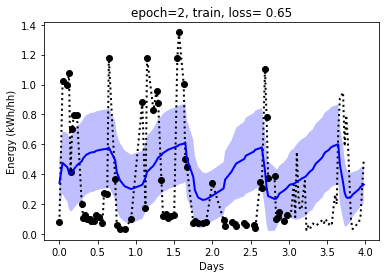

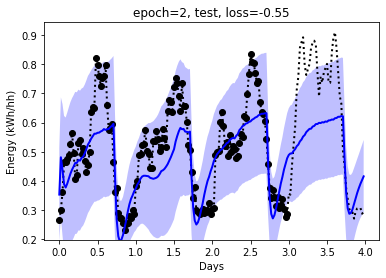

epoch: 2, loss: -0.3009, loss_test:-0.55, kl= 0, grad_norm:  3.7


3, i=0, loss: -0.4678, test: -0.5465, grad_norm:  0.99, std:  0.18
3, i=100, loss: -0.2823, test: -0.4457, grad_norm:  1.4, std:  0.19
3, i=200, loss: -0.2464, test: -0.5766, grad_norm:  1.3, std:  0.19
3, i=300, loss: -0.3157, test: -0.4916, grad_norm:  1.4, std:  0.19
3, i=400, loss: -0.3253, test: -0.5686, grad_norm:  4, std:  0.19
3, i=500, loss: -0.3355, test: -0.5429, grad_norm:  1.2, std:  0.19
3, i=600, loss: -0.3532, test: -0.5643, grad_norm:  1.4, std:  0.18
3, i=700, loss: -0.4328, test: -0.4828, grad_norm:  1.1, std:  0.18
3, i=800, loss: -0.2651, test: -0.5015, grad_norm:  2.1, std:  0.18
3, i=900, loss: -0.3806, test: -0.5318, grad_norm:  1.3, std:  0.18
3, i=1000, loss: -0.3408, test: -0.4825, grad_norm:  2, std:  0.18


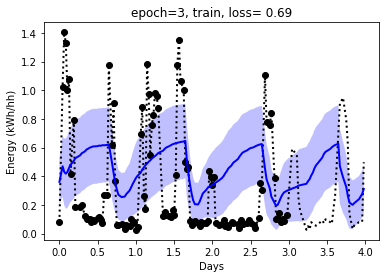

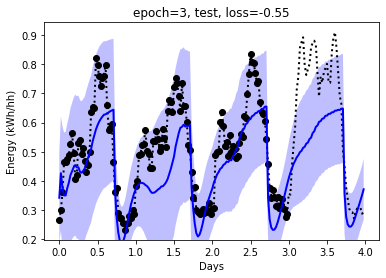

epoch: 3, loss: -0.462, loss_test:-0.5482, kl= 0, grad_norm:  2.5


4, i=0, loss: -0.4484, test: -0.5443, grad_norm:  1.3, std:  0.18
4, i=100, loss: -0.2656, test: -0.5822, grad_norm:  1.7, std:  0.18
4, i=200, loss: -0.2534, test: -0.6087, grad_norm:  2.3, std:  0.17
4, i=300, loss: -0.4604, test: -0.5103, grad_norm:  1.2, std:  0.17
4, i=400, loss: -0.4541, test: -0.6221, grad_norm:  1.2, std:  0.16
4, i=500, loss: -0.4907, test: -0.6677, grad_norm:  4.4, std:  0.17
4, i=600, loss: -0.4688, test: -0.6643, grad_norm:  2.2, std:  0.17
4, i=700, loss: -0.5413, test: -0.6931, grad_norm:  2.2, std:  0.17
4, i=800, loss: -0.4248, test: -0.6514, grad_norm:  1.8, std:  0.16
4, i=900, loss: -0.5386, test: -0.6938, grad_norm:  1.4, std:  0.15
4, i=1000, loss: -0.5611, test: -0.7203, grad_norm:  1.8, std:  0.15


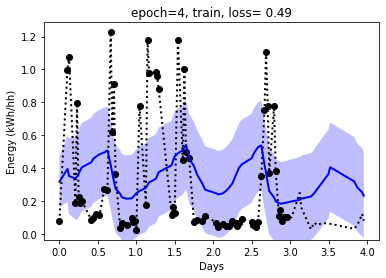

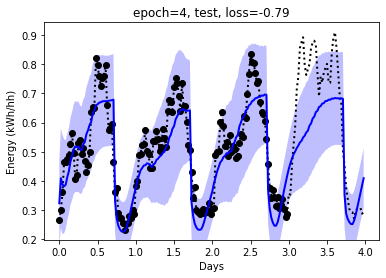

epoch: 4, loss: -0.619, loss_test:-0.7897, kl= 0, grad_norm:  12


5, i=0, loss: -0.4981, test: -0.7936, grad_norm:  1.6, std:  0.15
5, i=100, loss: -0.5467, test: -0.7361, grad_norm:  2.8, std:  0.15
5, i=200, loss: -0.3958, test: -0.7407, grad_norm:  1.7, std:  0.16
5, i=300, loss: -0.6375, test: -0.8088, grad_norm:  1.5, std:  0.15
5, i=400, loss: -0.5672, test: -0.8061, grad_norm:  2.6, std:  0.16
5, i=500, loss: -0.5091, test: -0.7956, grad_norm:  2.3, std:  0.15
5, i=600, loss: -0.3578, test: -0.7593, grad_norm:  1.9, std:  0.16
5, i=700, loss: -0.5049, test: -0.8332, grad_norm:  1.9, std:  0.16
5, i=800, loss: -0.3613, test: -0.8439, grad_norm:  3.4, std:  0.16
5, i=900, loss: -0.5896, test: -0.7868, grad_norm:  1.1, std:  0.15
5, i=1000, loss: -0.5948, test: -0.8391, grad_norm:  1.9, std:  0.15


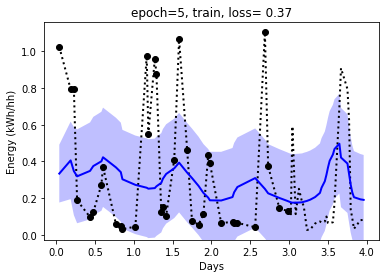

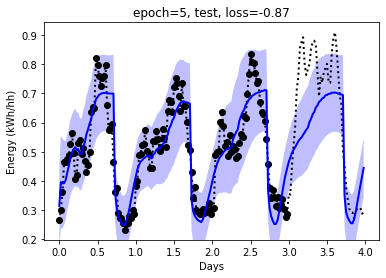

epoch: 5, loss: -0.8932, loss_test:-0.867, kl= 0, grad_norm:  2.4


6, i=0, loss: -0.5383, test: -0.8663, grad_norm:  1.8, std:  0.15
6, i=100, loss: -0.7138, test: -0.8538, grad_norm:  1.3, std:  0.14
6, i=200, loss: -0.3985, test: -0.8017, grad_norm:  1.6, std:  0.17
6, i=300, loss: -0.6672, test: -0.871, grad_norm:  3.4, std:  0.14
6, i=400, loss: -0.4977, test: -0.8556, grad_norm:  1.5, std:  0.16
6, i=500, loss: -0.3432, test: -0.8351, grad_norm:  2.7, std:  0.16
6, i=600, loss: -0.6867, test: -0.8425, grad_norm:  2.3, std:  0.14
6, i=700, loss: -0.4768, test: -0.8704, grad_norm:  2.8, std:  0.15
6, i=800, loss: -0.4908, test: -0.8867, grad_norm:  2.3, std:  0.15
6, i=900, loss: -0.5306, test: -0.8915, grad_norm:  2.7, std:  0.16
6, i=1000, loss: -0.7073, test: -0.9044, grad_norm:  2.4, std:  0.14


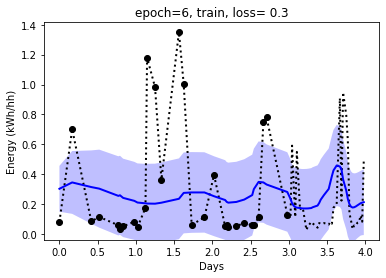

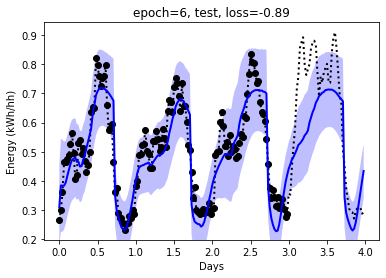

epoch: 6, loss: -0.622, loss_test:-0.8926, kl= 0, grad_norm:  1.2


7, i=0, loss: -0.633, test: -0.8979, grad_norm:  2.7, std:  0.15
7, i=100, loss: -0.6154, test: -0.8883, grad_norm:  2.1, std:  0.14
7, i=200, loss: -0.3874, test: -0.9181, grad_norm:  3.9, std:  0.14
7, i=300, loss: -0.5381, test: -0.8986, grad_norm:  5.3, std:  0.15
7, i=400, loss: -0.8006, test: -0.9152, grad_norm:  1.7, std:  0.13
7, i=500, loss: -0.4919, test: -0.9184, grad_norm:  6.3, std:  0.14
7, i=600, loss: -0.4856, test: -0.8989, grad_norm:  2.2, std:  0.16
7, i=700, loss: -0.712, test: -0.9045, grad_norm:  5.3, std:  0.13
7, i=800, loss: -0.7204, test: -0.9375, grad_norm:  2.9, std:  0.14
7, i=900, loss: -0.5432, test: -0.8578, grad_norm:  2.3, std:  0.15
7, i=1000, loss: -0.6811, test: -0.8765, grad_norm:  2.4, std:  0.13


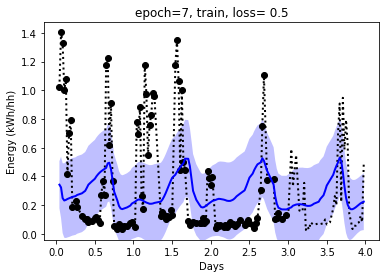

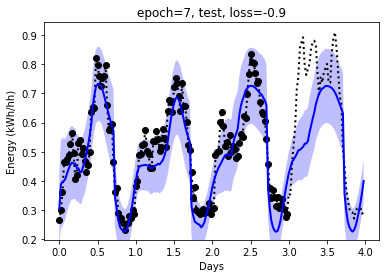

epoch: 7, loss: -0.5265, loss_test:-0.9028, kl= 0, grad_norm:  2.4


8, i=0, loss: -0.6373, test: -0.9058, grad_norm:  3.2, std:  0.13
8, i=100, loss: -0.6786, test: -0.8967, grad_norm:  1.6, std:  0.14
8, i=200, loss: -0.7869, test: -0.9161, grad_norm:  1.7, std:  0.13
8, i=300, loss: -0.8447, test: -0.8725, grad_norm:  1.4, std:  0.13
8, i=400, loss: -0.6472, test: -0.8923, grad_norm:  2, std:  0.14
8, i=500, loss: -0.7806, test: -0.9706, grad_norm:  1.3, std:  0.13
8, i=600, loss: -0.7856, test: -0.8882, grad_norm:  4.5, std:  0.13
8, i=700, loss: -0.8017, test: -0.9287, grad_norm:  1.6, std:  0.12
8, i=800, loss: -0.6581, test: -0.96, grad_norm:  1.3, std:  0.14
8, i=900, loss: -0.8221, test: -0.8808, grad_norm:  1.5, std:  0.13
8, i=1000, loss: -0.7996, test: -0.859, grad_norm:  3.6, std:  0.13


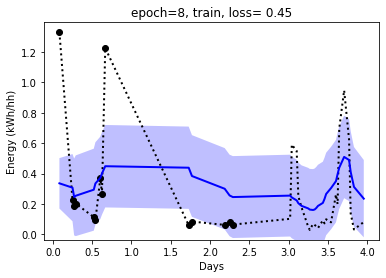

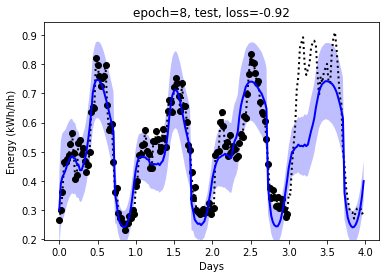

epoch: 8, loss: -0.619, loss_test:-0.9222, kl= 0, grad_norm:  1.3


9, i=0, loss: -0.8102, test: -0.9181, grad_norm:  1.5, std:  0.13
9, i=100, loss: -0.7081, test: -0.916, grad_norm:  2, std:  0.14
9, i=200, loss: -0.7337, test: -0.8792, grad_norm:  1.6, std:  0.14
9, i=300, loss: -0.6487, test: -0.8681, grad_norm:  2.9, std:  0.14
9, i=400, loss: -0.855, test: -1.016, grad_norm:  1.4, std:  0.13
9, i=500, loss: -0.8126, test: -0.8107, grad_norm:  1.3, std:  0.13
9, i=600, loss: -0.8455, test: -0.8904, grad_norm:  1.5, std:  0.12
9, i=700, loss: -0.6028, test: -0.7902, grad_norm:  2.7, std:  0.13
9, i=800, loss: -0.3507, test: -0.9146, grad_norm:  4.5, std:  0.15
9, i=900, loss: -0.7835, test: -0.9265, grad_norm:  1.9, std:  0.13
9, i=1000, loss: -0.7339, test: -0.8719, grad_norm:  4.9, std:  0.13


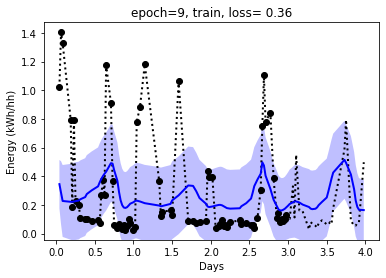

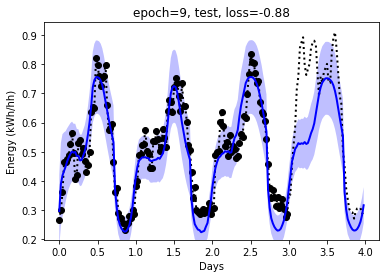

epoch: 9, loss: -0.855, loss_test:-0.8846, kl= 0, grad_norm:  6.6


10, i=0, loss: -0.7274, test: -0.8343, grad_norm:  2, std:  0.13
10, i=100, loss: -0.7544, test: -0.7731, grad_norm:  2.4, std:  0.13
10, i=200, loss: -0.7148, test: -0.9783, grad_norm:  1.4, std:  0.14
10, i=300, loss: -1.033, test: -0.8684, grad_norm:  1.7, std:  0.11
10, i=400, loss: -0.5015, test: -0.8473, grad_norm:  2.3, std:  0.14
10, i=500, loss: -0.9413, test: -0.8914, grad_norm:  1.6, std:  0.12
10, i=600, loss: -0.8815, test: -0.8435, grad_norm:  2.4, std:  0.12
10, i=700, loss: -0.5102, test: -0.8921, grad_norm:  1.3, std:  0.14
10, i=800, loss: -0.9758, test: -0.7977, grad_norm:  1.6, std:  0.11
10, i=900, loss: -0.7731, test: -0.8164, grad_norm:  1.6, std:  0.13
10, i=1000, loss: -0.7234, test: -0.8739, grad_norm:  3.4, std:  0.13


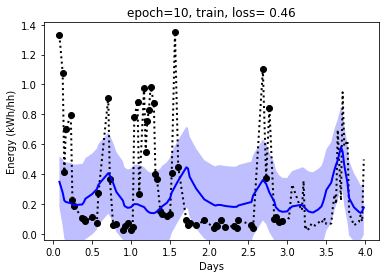

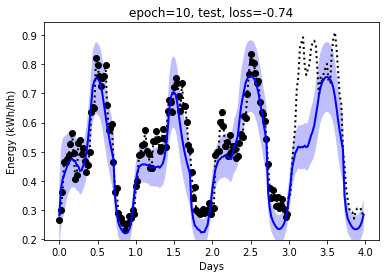

epoch: 10, loss: -0.7163, loss_test:-0.7369, kl= 0, grad_norm:  6.3


11, i=0, loss: -1.026, test: -0.7567, grad_norm:  1.8, std:  0.11
11, i=100, loss: -0.9488, test: -0.8816, grad_norm:  3.2, std:  0.11
11, i=200, loss: -0.339, test: -0.9567, grad_norm:  5.5, std:  0.13
11, i=300, loss: -1.057, test: -0.8943, grad_norm:  4.4, std:  0.11
11, i=400, loss: -0.8167, test: -0.9797, grad_norm:  1.8, std:  0.13
11, i=500, loss: -0.7506, test: -0.9022, grad_norm:  4.9, std:  0.13
11, i=600, loss: -0.882, test: -0.8786, grad_norm:  2.6, std:  0.12
11, i=700, loss: -0.8641, test: -0.895, grad_norm:  1.5, std:  0.12
11, i=800, loss: -1.041, test: -0.7577, grad_norm:  1.5, std:  0.11
11, i=900, loss: -1.098, test: -0.9168, grad_norm:  2.2, std:  0.1
11, i=1000, loss: -0.9416, test: -0.7812, grad_norm:  1.9, std:  0.12


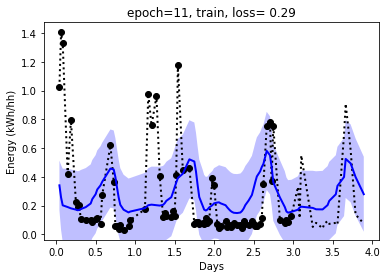

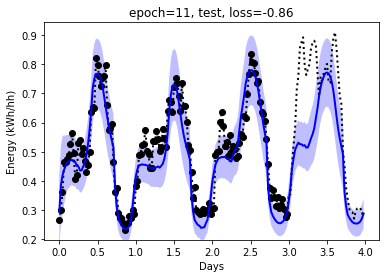

epoch: 11, loss: 0.8057, loss_test:-0.8631, kl= 0, grad_norm:  35


12, i=0, loss: -0.9468, test: -0.8638, grad_norm:  1.7, std:  0.11
12, i=100, loss: -0.6088, test: -0.8377, grad_norm:  2, std:  0.14
12, i=200, loss: -0.9865, test: -0.872, grad_norm:  1.5, std:  0.11
12, i=300, loss: -1.199, test: -0.7904, grad_norm:  2, std:  0.098
12, i=400, loss: -0.5968, test: -0.8906, grad_norm:  1.9, std:  0.14
12, i=500, loss: -0.9861, test: -0.8155, grad_norm:  2.5, std:  0.11
12, i=600, loss: -1.009, test: -0.8095, grad_norm:  4.5, std:  0.11
12, i=700, loss: -1.069, test: -0.7913, grad_norm:  1.7, std:  0.11
12, i=800, loss: -0.8656, test: -0.8175, grad_norm:  1.8, std:  0.11
12, i=900, loss: -0.8762, test: -0.9144, grad_norm:  1.5, std:  0.12
12, i=1000, loss: -0.3726, test: -0.7826, grad_norm:  6.1, std:  0.14


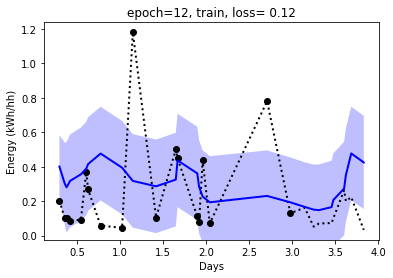

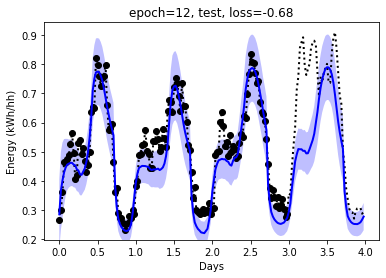

epoch: 12, loss: -0.9093, loss_test:-0.6761, kl= 0, grad_norm:  4.7


13, i=0, loss: -0.7625, test: -0.6671, grad_norm:  4.2, std:  0.12
13, i=100, loss: -0.8935, test: -0.7875, grad_norm:  2.5, std:  0.12
13, i=200, loss: -0.8868, test: -0.7856, grad_norm:  3.3, std:  0.11
13, i=300, loss: -0.9888, test: -0.9389, grad_norm:  1.6, std:  0.11
13, i=400, loss: -0.8787, test: -0.7351, grad_norm:  1.8, std:  0.12
13, i=500, loss: -1.037, test: -0.6288, grad_norm:  2, std:  0.11
13, i=600, loss: -0.9866, test: -0.6882, grad_norm:  1.4, std:  0.11
13, i=700, loss: -0.9483, test: -0.8421, grad_norm:  1.5, std:  0.11
13, i=800, loss: -0.7698, test: -0.7102, grad_norm:  2.2, std:  0.13
13, i=900, loss: -0.9609, test: -0.7621, grad_norm:  3.1, std:  0.11
13, i=1000, loss: -0.7945, test: -0.5873, grad_norm:  6.5, std:  0.11


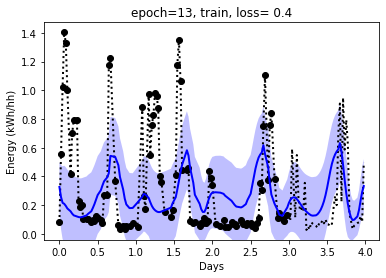

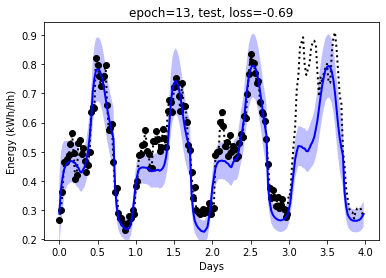

epoch: 13, loss: -0.245, loss_test:-0.6876, kl= 0, grad_norm:  11


14, i=0, loss: -0.7418, test: -0.6835, grad_norm:  1.2, std:  0.13
14, i=100, loss: -0.7715, test: -0.8454, grad_norm:  2.7, std:  0.12
14, i=200, loss: -0.9693, test: -0.8518, grad_norm:  2.6, std:  0.11
14, i=300, loss: -0.8669, test: -0.9604, grad_norm:  5.3, std:  0.12
14, i=400, loss: -0.9431, test: -0.88, grad_norm:  2, std:  0.11
14, i=500, loss: -0.7786, test: -0.824, grad_norm:  1.7, std:  0.12
14, i=600, loss: -0.9387, test: -0.7941, grad_norm:  2.7, std:  0.12
14, i=700, loss: -0.8699, test: -0.9205, grad_norm:  1.4, std:  0.12
14, i=800, loss: -0.9496, test: -0.8361, grad_norm:  2, std:  0.11
14, i=900, loss: -0.9152, test: -0.8477, grad_norm:  1.7, std:  0.12
14, i=1000, loss: -0.9148, test: -0.7616, grad_norm:  1.3, std:  0.12


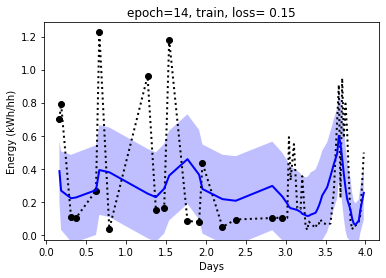

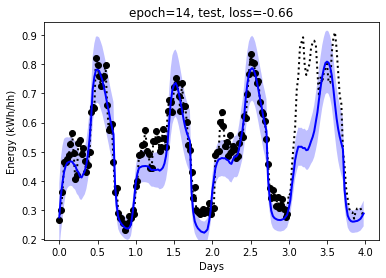

epoch: 14, loss: 1.294, loss_test:-0.6563, kl= 0, grad_norm:  38


15, i=0, loss: -1.13, test: -0.7148, grad_norm:  1.8, std:  0.097
15, i=100, loss: -0.9254, test: -0.7558, grad_norm:  2, std:  0.11
15, i=200, loss: -0.8878, test: -0.8051, grad_norm:  3.6, std:  0.11
15, i=300, loss: -0.5292, test: -0.7379, grad_norm:  2, std:  0.15
15, i=400, loss: -0.8354, test: -0.6678, grad_norm:  1.4, std:  0.12
15, i=500, loss: -0.7768, test: -0.5928, grad_norm:  23, std:  0.12
15, i=600, loss: -1.087, test: -0.6443, grad_norm:  1.8, std:  0.1
15, i=700, loss: -0.9713, test: -0.8983, grad_norm:  2.5, std:  0.11
15, i=800, loss: -0.6269, test: -0.7156, grad_norm:  6.2, std:  0.12
15, i=900, loss: -1.073, test: -0.8415, grad_norm:  2.9, std:  0.098
15, i=1000, loss: -1.122, test: -0.8136, grad_norm:  3.7, std:  0.1


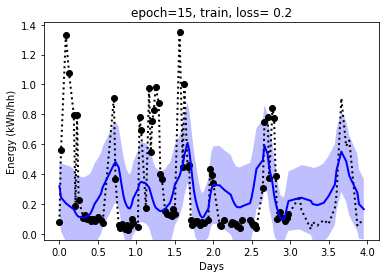

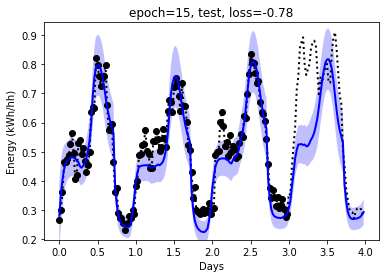

epoch: 15, loss: -0.9695, loss_test:-0.7803, kl= 0, grad_norm:  3.1


16, i=0, loss: -0.9496, test: -0.7889, grad_norm:  1.6, std:  0.11
16, i=100, loss: -0.9522, test: -0.5988, grad_norm:  2.2, std:  0.11
16, i=200, loss: -0.7856, test: -0.6312, grad_norm:  3.5, std:  0.12
16, i=300, loss: -1.1, test: -0.6939, grad_norm:  2.7, std:  0.099
16, i=400, loss: -0.9863, test: -0.6468, grad_norm:  2.9, std:  0.11
16, i=500, loss: -0.9145, test: -0.6299, grad_norm:  1.9, std:  0.12
16, i=600, loss: -0.8921, test: -0.7642, grad_norm:  2.6, std:  0.12
16, i=700, loss: -1.023, test: -0.6578, grad_norm:  1.3, std:  0.11
16, i=800, loss: -0.8592, test: -0.6485, grad_norm:  2.7, std:  0.12
16, i=900, loss: -1.17, test: -0.7743, grad_norm:  2.1, std:  0.095
16, i=1000, loss: -0.9222, test: -0.701, grad_norm:  1.7, std:  0.12


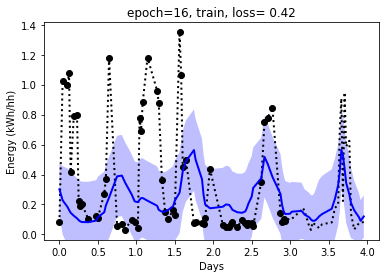

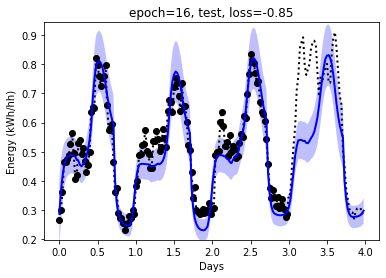

epoch: 16, loss: 0.7173, loss_test:-0.8476, kl= 0, grad_norm:  41


17, i=0, loss: -1.055, test: -0.8205, grad_norm:  2, std:  0.11
17, i=100, loss: -0.8783, test: -0.7115, grad_norm:  3.2, std:  0.11
17, i=200, loss: -1.037, test: -0.5905, grad_norm:  2.9, std:  0.1
17, i=300, loss: -1.1, test: -0.6239, grad_norm:  2.2, std:  0.1
17, i=400, loss: -1.078, test: -0.8238, grad_norm:  2, std:  0.098
17, i=500, loss: -1.234, test: -0.6812, grad_norm:  1.3, std:  0.088
17, i=600, loss: -0.9319, test: -0.6246, grad_norm:  2.1, std:  0.12
17, i=700, loss: -1.047, test: -0.6368, grad_norm:  1.6, std:  0.1
17, i=800, loss: -0.9432, test: -0.6724, grad_norm:  2.9, std:  0.11
17, i=900, loss: -1.027, test: -0.7792, grad_norm:  2.3, std:  0.1
17, i=1000, loss: -1.151, test: -0.8113, grad_norm:  1.8, std:  0.094


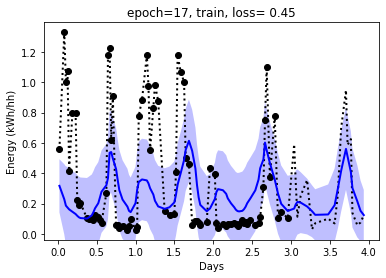

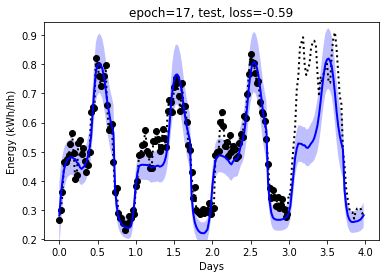

epoch: 17, loss: -0.6061, loss_test:-0.5942, kl= 0, grad_norm:  3.8


18, i=0, loss: -0.7101, test: -0.5542, grad_norm:  1.9, std:  0.13
18, i=100, loss: -1.085, test: -0.8498, grad_norm:  2.1, std:  0.1
18, i=200, loss: -0.6941, test: -0.597, grad_norm:  1.9, std:  0.13
18, i=300, loss: -1.082, test: -0.6886, grad_norm:  1.7, std:  0.1
18, i=400, loss: -1.012, test: -0.751, grad_norm:  2.2, std:  0.1
18, i=500, loss: -0.9566, test: -0.792, grad_norm:  2.3, std:  0.11
18, i=600, loss: -0.7857, test: -0.7542, grad_norm:  3.2, std:  0.12
18, i=700, loss: -0.9541, test: -0.8, grad_norm:  1.9, std:  0.11
18, i=800, loss: -0.9275, test: -0.7147, grad_norm:  2.6, std:  0.12
18, i=900, loss: -1.11, test: -0.8733, grad_norm:  2.9, std:  0.099
18, i=1000, loss: -0.6004, test: -0.9139, grad_norm:  2.7, std:  0.14


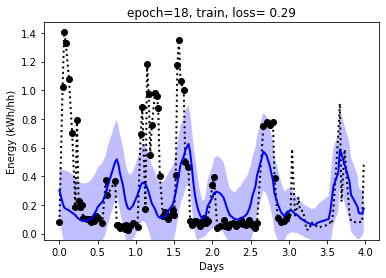

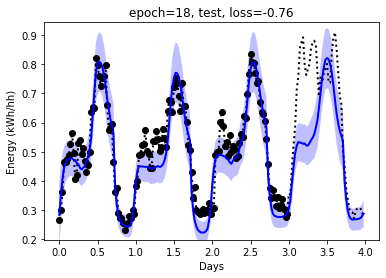

epoch: 18, loss: -0.7376, loss_test:-0.7619, kl= 0, grad_norm:  9.6


19, i=0, loss: -0.9718, test: -0.7874, grad_norm:  3.2, std:  0.1
19, i=100, loss: -0.9409, test: -0.865, grad_norm:  2.2, std:  0.11
19, i=200, loss: -1.179, test: -0.6137, grad_norm:  1.9, std:  0.096
19, i=300, loss: -1.015, test: -0.7895, grad_norm:  2.4, std:  0.11
19, i=400, loss: -1.083, test: -0.7982, grad_norm:  2.1, std:  0.098
19, i=500, loss: -0.9448, test: -0.8094, grad_norm:  3.3, std:  0.11
19, i=600, loss: -1.028, test: -0.7841, grad_norm:  1.9, std:  0.1
19, i=700, loss: -1.164, test: -0.7546, grad_norm:  2.1, std:  0.097
19, i=800, loss: -1.036, test: -0.7428, grad_norm:  3.6, std:  0.11
19, i=900, loss: -0.9769, test: -0.6623, grad_norm:  2.8, std:  0.11
19, i=1000, loss: -1.15, test: -0.501, grad_norm:  2.3, std:  0.092


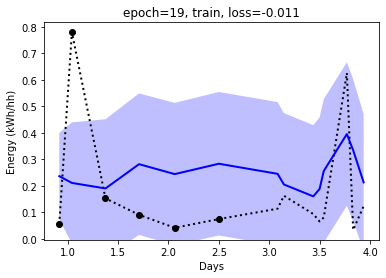

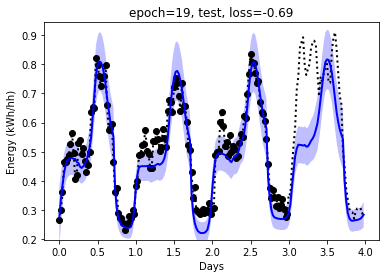

epoch: 19, loss: -0.05559, loss_test:-0.6854, kl= 0, grad_norm:  12


In [83]:
epochs = 20
grad_clip = 10
history = []
for epoch in tqdm(range(epochs), unit='epoch'):

    pbar = tqdm(loader_train, unit='batch')
    for i, data in enumerate(pbar):
        model.train()
        assert all(torch.isfinite(d).all() for d in data)
        data = [d.to(device) for d in data]
        context_x, context_y, target_x, target_y = data

        optim.zero_grad()
        y_pred, kl, loss, y_std = model(context_x, context_y, target_x, target_y)

        # These attentive NP models work great when you need uncertainty, but still seem a bit unstable. 
        # Sometimes they produce nans, especically if the data is not fully normalized. 
        assert torch.isfinite(y_pred.sum())
        if not torch.isfinite(loss):
            logger.error("loss is not finite")
            continue
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        if not np.isfinite(grad_norm):
            logger.error("grad_norm is not finite")
            continue
        optim.step()

        if i%100==0:
            model.eval()
            test_loss = plot_from_loader(loader_test, i=vis_i, plot=False)
            pbar.set_description(f"{epoch}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}")
            print(f"{epoch}, i={i}, loss: {loss.item():4.4g}, test: {test_loss.item():4.4g}, grad_norm: {grad_norm: 2.2g}, std: {y_std.mean().item(): 2.2g}")
            
            history.append(dict(
                n=epoch*len(loader_train) + i,
                epoch=epoch,
                i=i,
                loss=loss.item(),
                kl=kl.mean().item(),
                test_loss=test_loss.item(),
                y_std=y_std.mean().item(),
                grad_norm=grad_norm,
            ))
        
    test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
    model.eval()
    test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')
    print(f"epoch: {epoch}, loss: {loss.item():4.4g}, loss_test:{test_loss.item():4.4g}, kl={kl.mean().item():2.2g}, grad_norm: {grad_norm: 2.2g}")

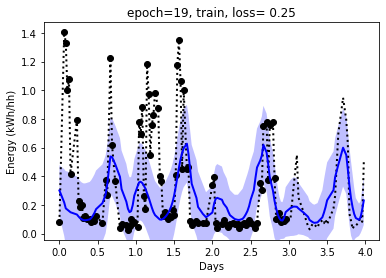

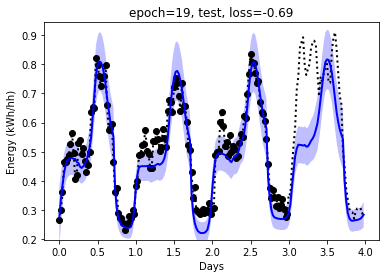

In [84]:
test_loss = plot_from_loader(loader_train, i=vis_i, title=f'epoch={epoch}, train,')
model.eval()
test_loss = plot_from_loader(loader_test, i=vis_i, title=f'epoch={epoch}, test,')

## History

In [85]:
df_hist = pd.DataFrame(history)
df_hist['n'] = df_hist['epoch'] * len(loader_train) + df_hist['i']
df_hist = df_hist.set_index('n')
df_hist.head(3)

,epoch,grad_norm,i,kl,loss,test_loss,y_std
n,,,,,,,
0,0,41.036319,0,0.0,5.767507,7.514725,0.093203
100,0,2.483919,100,0.0,0.208696,-0.274699,0.169012
200,0,0.903813,200,0.0,-0.002053,-0.211399,0.209763


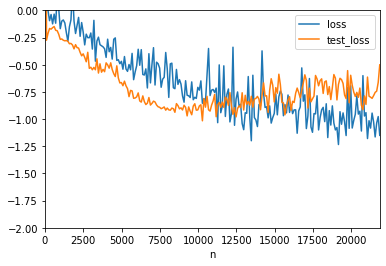

In [86]:
(df_hist[['loss', 'test_loss']]).plot(ylim=[-2,0])

/home/wassname/.pyenv/versions/3.7.2/envs/jup3.7.2/lib/python3.7/site-packages/pandas/plotting/_core.py:441: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


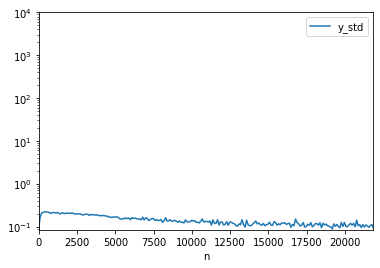

In [87]:
df_hist[['y_std']].plot(ylim=[0,1e4], logy=True)

In [88]:
df_hist[100:]

,epoch,grad_norm,i,kl,loss,test_loss,y_std
n,,,,,,,
9982,9,1.990812,100,0.0,-0.708131,-0.915956,0.139813
10082,9,1.641308,200,0.0,-0.733692,-0.879152,0.136099
10182,9,2.888346,300,0.0,-0.648740,-0.868099,0.137650
10282,9,1.421261,400,0.0,-0.854953,-1.015807,0.125692
10382,9,1.265368,500,0.0,-0.812582,-0.810697,0.126962
10482,9,1.457197,600,0.0,-0.845517,-0.890357,0.121595
10582,9,2.746658,700,0.0,-0.602812,-0.790208,0.133653
10682,9,4.451844,800,0.0,-0.350703,-0.914606,0.152084
10782,9,1.860946,900,0.0,-0.783548,-0.926471,0.127733


In [64]:
len(loader_test)

117